Learn vanishing gradients to know advantages of inception net, also look at the ResnetOnGithubDS before looking at this code

This model takes images as 224x224

In [36]:
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
import os
import torch
import torchvision
import torch.utils.data
from PIL import Image

In [38]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(512,512))])

# path = r"/content/drive/MyDrive/Datasets for glycoma/MyOrigaFolder" #for colab
# path = r"D:\Datasets\MyOrigaFolder"  # for windows

#git hub dataset
path = r"D:\Datasets\dataset\train"  # for windows
test_path = r"D:\Datasets\dataset\test"  # for windows
my_ds1 = ImageFolder(path, transform=transform)

In [39]:
img, label = my_ds1[80]
print(img.shape)
print(label)

torch.Size([3, 512, 512])
0


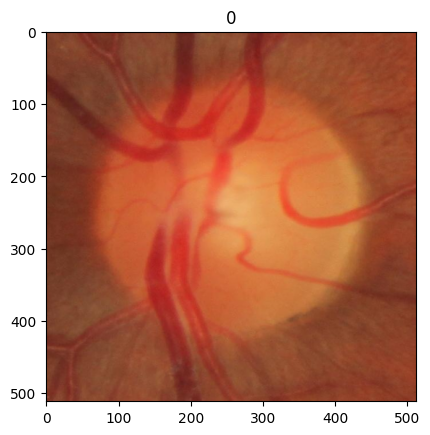

In [40]:
from torch.utils.data import Dataset
import torchvision.transforms as tt
import matplotlib.pyplot as plt
# see youtube vid about how to create custom datasets
# https://www.analyticsvidhya.com/blog/2021/09/torch-dataset-and-dataloader-early-loading-of-data/
# https://youtu.be/NVxCKdp0NhQ


dataloader = torch.utils.data.DataLoader(my_ds1, batch_size=36, shuffle=False)

toPil = tt.ToPILImage()

for img, label in dataloader:
    plt.title(label=label[35].item())
    plt.imshow(toPil(img[35]))
    break


# checked the customDS and dataloader, and they were tested/crosschecked to be found ok, img 36 in OG dataset is with glycoma and the label we got from dataloader is 1

In [41]:
import torchvision.transforms as tt

In [42]:
import torchvision.transforms as tt

#normalize is not working properly, ie its not giving values between -1 and 1

train_transforms = tt.Compose([
    
    tt.ToTensor(),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    tt.RandomRotation(degrees=45),
    # tt.Normalize([0.64566187, 0.29739011, 0.17928236],[0.14744558, 0.11072611, 0.07712533]),
    transforms.Resize(size=(224,224)),
])
test_transforms = tt.Compose([
    tt.ToTensor(),
    # tt.Normalize([0.65267069, 0.30094331, 0.17525753], [0.14621546, 0.1140823,  0.08098041]),
    transforms.Resize(size=(224,224)),
])



my_ds1 = None  # this souldnt be used now so mark it as None

train_ds = ImageFolder(path, transform=train_transforms)
test_ds = ImageFolder(test_path, transform=test_transforms)

print(len(train_ds))
print(len(test_ds))
print(len(train_ds) + len(test_ds))
# print(train_ds[1])

455
64
519


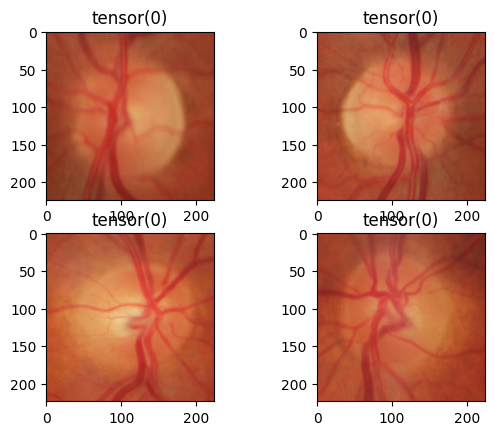

In [43]:
trainLoader = torch.utils.data.DataLoader(train_ds, 4, shuffle=True,)
testLoader = torch.utils.data.DataLoader(test_ds, 4, shuffle=False,)

# lets see if we can apply our transforms
for img, label in testLoader:

    # transformed_imgs_batch = [train_transforms(one_img) for one_img in img] #train_transforms can only take one img at a time

    plt.subplot(2, 2, 1)
    plt.title(label=label[0])
    plt.imshow(img[0].permute(1, 2, 0))

    plt.subplot(2, 2, 2)
    plt.title(label[0])
    # applying/testing our trnsform func, FIRST APPLY the transforms func then apply the .premute()
    plt.imshow(img[1].permute(1, 2, 0))

    plt.subplot(2, 2, 3)
    plt.title(label[2])
    plt.imshow(img[2].permute(1, 2, 0))

    plt.subplot(2, 2, 4)
    plt.title(label[3])
    plt.imshow(img[3].permute(1, 2, 0))

    break

In [44]:
import torch.nn as nn
import torch.functional as F

In [45]:
# IMPORANT!!!!!!!!!!!!!!!! These functions return data and do not do it inplace, make sure to assign the return values to a variable


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [46]:
import torch.nn.functional as F


def train_step(model, input_batch, actual_outputs, loss_func):
        pred = model(input_batch)
        loss = loss_func(pred, actual_outputs)
        return loss 

def accuracy(outputs, labels):
        preds = torch.Tensor([[round(x.item())]  for x in outputs]) #the preds should be of shape [4,1]
        preds = to_device(preds, get_default_device()) # IMPORANT!!!!!!!!!!!!!!!! These functions return data and do not do it inplace, make sure to assign the return values to a variable
        acc = torch.sum(preds == labels).item() / len(preds)
        return acc

def validation(model, trainLoader, loss_func):
        with torch.no_grad(): # IMPORTANT!!!!!! Remeber to put with torch.no_grad() when testing the model or the gradients will keep accumulating and the memory will run out
            losses_sum = 0
            accuracies_sum = 0
            counter = 0
            model.eval()
            for imgs, labels in trainLoader:
                predictions = model(imgs)
                labels = torch.unsqueeze(labels, 1) # get the labels to shape [4,1]
                # also change dtype of labels frm int64 to float32
                labels = labels.type(torch.float32)

                loss  = loss_func(predictions, labels)
                losses_sum += loss

                acc = accuracy(predictions, labels)
                accuracies_sum += acc

                counter += 1

                avg_acc = accuracies_sum/counter
                avg_loss = losses_sum/counter

                # print(f" avg_acc = {avg_acc}")

        return avg_acc,avg_loss




def fit_model(model, lr, trainLoader, epochs, opt=torch.optim.Adam, train_transforms=train_transforms, loss_func = F.binary_cross_entropy, grad_clip_value=None):

    optimizer = opt(model.parameters(), lr,)
    model.train()

    lr_schduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.1,patience=2,verbose=True)
    

    for epoch in range(epochs):

        epoch_losses = []

        for imgs, labels in trainLoader:
            labels = torch.unsqueeze(labels, 1) # get the labels to shape [4,1]
            # also change dtype of labels frm int64 to float32
            labels = labels.type(torch.float32)

            loss = train_step(model, imgs, labels, loss_func)
            loss.backward()

            if grad_clip_value!=None:
                nn.utils.clip_grad.clip_grad_value_(model.parameters(), grad_clip_value)
        

            optimizer.step()
            optimizer.zero_grad()

            epoch_losses.append(loss.item())

        avg_loss = sum(epoch_losses)/len(epoch_losses)
        print(f"Avg loss for epoch {epoch} = {avg_loss}")
        lr_schduler.step(avg_loss)

            



    acc,loss = validation(model, trainLoader, loss_func)
    print(f"Done! Accuracy: {acc} & Loss: {loss}")









TypeError: EnumType.__call__() missing 1 required positional argument: 'value'

In [62]:
# https://sh-tsang.medium.com/review-vision-transformer-vit-406568603de0
# read the above link to know more about b,l,h

# model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1) # 86M params
# model = torchvision.models.vit_l_16() # 304M params (which is too much even for colab)
model = torchvision.models.vit_h_14(weights=torchvision.models.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1) # 632M params (which is too much even for colab)
print(model)

#freezing all the weights
for param in model.parameters():
    param.requires_grad = False

num_of_input_features = model.heads.head.in_features
print(num_of_input_features)
# the below layer has param.requires_grad = True by default
model.heads.head = nn.Sequential(
    nn.Linear(num_of_input_features, out_features=1),
    nn.Sigmoid(),
)




VisionTransformer(
  (conv_proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=5120, out_features=1280, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
       

In [48]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 85799425


In [50]:
# why doenst this inception net have auxillary logits/outputs like the inceptionnet v3????????
for img, label in trainLoader:
    print(img.shape)
    print(label)
    local_output = model(img)
    print(local_output)
    break
    

torch.Size([4, 3, 224, 224])
tensor([0, 1, 1, 0])
tensor([[0.4274],
        [0.4141],
        [0.4044],
        [0.4397]], grad_fn=<SigmoidBackward0>)


Moving to gpu


In [52]:
device = get_default_device()

model = to_device(model, device)

trainLoader = DeviceDataLoader(trainLoader, device)
testLoader = DeviceDataLoader(testLoader, device)

In [53]:
print(device)
# print(model)

cpu


In [54]:
print("Initial acc:")  
validation(model, testLoader, F.binary_cross_entropy)

Initial acc:


(0.5, tensor(0.6885))

In [55]:
fit_model(model, 0.00001, trainLoader, 1, grad_clip_value = 0.1)
# working confirmed!

KeyboardInterrupt: 

In [ ]:
import gc
gc.collect()

print(len(testLoader))

validation(model, testLoader, F.binary_cross_entropy)


# ALL THESE WERE TRAINED ON RANDOMIZED WEIGHTS, BE SURE TO TRAIN THEM AGAIN ON PRETRAINED WEIGHTS


# both the inception models are in another file
# Inception v3 (30 epochs, overfitting after this) acc = 82.8125%, initial acc = 0.5 (random guessing) no normailze() no grayscale(), lr = ReduceLROnPlateau, grad_clip value  = 0.1 
# InceptionResnetv2 test acc = 89.0625% (31 epoch, overfitting after this), initial acc = 0.5 (random guessing) no normailze() no grayscale(), lr = ReduceLROnPlateau, grad_clip value  = 0.1 (54 million params)


# only these models were trained on pre-trained weights, 
# after the given epochs the model overfit
# ViT (Vision transformers)( vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1) 85M params) 20 or 30? epochs acc = 82.8125, initial acc = 56% (only the classifier was trained, upper layers were frozen)
# ViT (Vision transformers)(vit_l_16(weights=torchvision.models.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1) 304M params) 10 epochs acc = 92.1875, initial acc = 48%  (only the classifier was trained, upper layers were frozen)

# after around 5 epochs resnet50 avg_acc = 93.75%, initial acc = 56, lr = ReduceLROnPlateau, grad_clip value  = 0.1, pre-trained weights = ResNet50_Weights.IMAGENET1K_V2, ALL LAYERS TRAINABLE

# DenseNet max acc = 98.4375% (8 epochs) , initial acc = 42%, lr = ReduceLROnPlateau, grad_clip value  = 0.1  pre-trained weights = DenseNet169_Weights.IMAGENET1K_V1, ALL LAYERS TRAINABLE

# efficientnet_b5 = 98.4375% (10 epochs), initial acc = 28%, lr = ReduceLROnPlateau, grad_clip value  = 0.1, pre-trained weights = EfficientNet_B5_Weights.IMAGENET1K_V1, ALL LAYERS TRAINABLE

# even tho vgg has a good acc it takes a lot of time to train caz it has lot of params (138M)
# VGG - 19BN max acc = 92.1875%, (7 epochs) initial acc = 50%, lr = ReduceLROnPlateau, grad_clip value  = 0.1, pre-trained weights = VGG19_BN_Weights.IMAGENET1K_V1, ALL LAYERS TRAINABLE


16


(0.5, tensor(0.6938))